# Sistema de Detección de Fraude Crediticio Inmobiliario

## Objetivo del Proyecto
Detectar **solicitudes de crédito fraudulentas** mediante la identificación de patrones anómalos, inconsistencias y comportamientos sospechosos en solicitudes de préstamos inmobiliarios.

### Diferencia Clave
- **Impago (default)**: Cliente legítimo que no puede pagar
- **Fraude**: Solicitud con intención de engañar desde el inicio
- **Nuestro enfoque**: Detectar casos con alta probabilidad de ser fraudulentos para revisión humana

## 1. Configuración del Entorno

In [6]:
# Instalación automática de dependencias faltantes
import subprocess
import sys

def instalar_paquete(paquete):
    """Instalar paquete si no está disponible"""
    try:
        subprocess.check_call([sys.executable, "-m", "pip", "install", paquete])
        return True
    except:
        return False


In [7]:
# Instalación automática de dependencias faltantes
import subprocess
import sys

def instalar_paquete(paquete):
    """Instalar paquete si no está disponible"""
    try:
        subprocess.check_call([sys.executable, "-m", "pip", "install", paquete])
        return True
    except:
        return False

# Verificar e instalar dependencias críticas
dependencias_criticas = ['lightgbm', 'shap']
for dep in dependencias_criticas:
    try:
        __import__(dep)
    except ImportError:
        instalar_paquete(dep)

# Librerías principales
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Machine Learning
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier, IsolationForest, GradientBoostingClassifier
from sklearn.neighbors import LocalOutlierFactor
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
from sklearn.metrics import (roc_auc_score, precision_recall_curve, average_precision_score,
                           precision_score, recall_score, f1_score, roc_curve, confusion_matrix,
                           silhouette_score)

# Gradient Boosting (con alternativa si falla)
try:
    import lightgbm as lgb
    LIGHTGBM_DISPONIBLE = True
    print("LightGBM disponible")
except ImportError:
    from sklearn.ensemble import GradientBoostingClassifier
    LIGHTGBM_DISPONIBLE = False
    print("LightGBM no disponible - usando GradientBoostingClassifier de sklearn")

# Deep Learning (opcional)
try:
    import tensorflow as tf
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense
    tf.random.set_seed(42)
    TENSORFLOW_DISPONIBLE = True
except ImportError:
    from sklearn.neural_network import MLPRegressor
    TENSORFLOW_DISPONIBLE = False

# Interpretabilidad (opcional)
try:
    import shap
    SHAP_DISPONIBLE = True
except ImportError:
    SHAP_DISPONIBLE = False

# Configuración general
import os
import gc
from typing import Tuple, Dict, List

SEMILLA_ALEATORIA = 42
np.random.seed(SEMILLA_ALEATORIA)
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)
sns.set_palette("husl")

c:\AA2 - Deteccion-de-fraude-inmobiliario\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


LightGBM disponible


## 2. Carga y Exploración de Datos

In [8]:
# Carga de datos
RUTA_DATOS = r"C:\AA2 - Deteccion-de-fraude-inmobiliario\data\data"
df = pd.read_csv(os.path.join(RUTA_DATOS, "application_train.csv"))

# Información básica del dataset
distribucion = df['TARGET'].value_counts()
tasa_base = df['TARGET'].mean()

# Resumen de datos para referencia
info_dataset = {
    'dimensiones': df.shape,
    'distribucion_target': distribucion,
    'tasa_base_riesgo': tasa_base,
    'casos_sin_problemas': distribucion[0],
    'casos_con_problemas': distribucion[1] if 1 in distribucion else 0
}

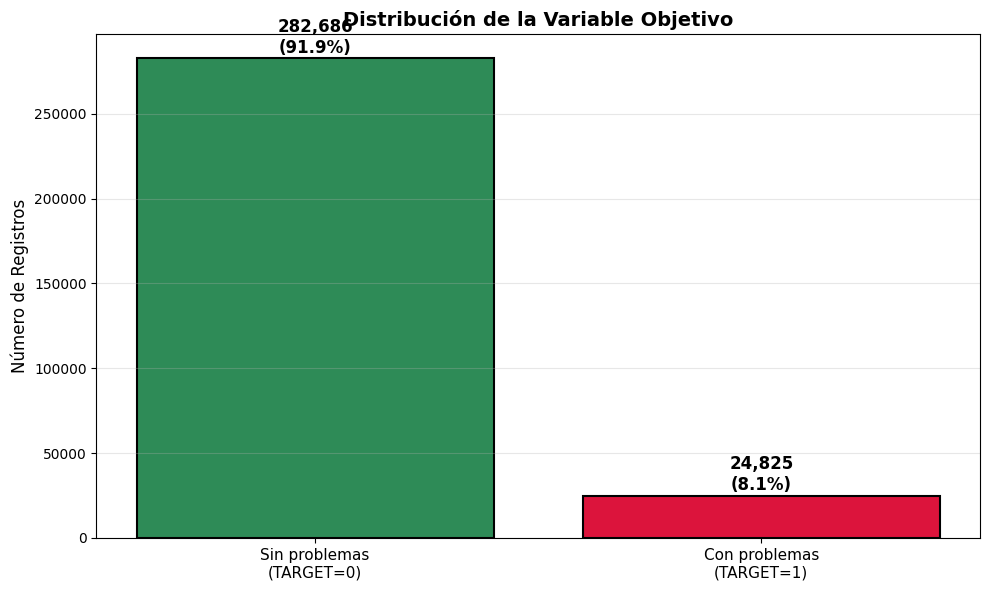

In [9]:
# Visualización de la distribución de TARGET
fig, ax = plt.subplots(figsize=(10, 6))

conteos = df['TARGET'].value_counts()
etiquetas = ['Sin problemas\n(TARGET=0)', 'Con problemas\n(TARGET=1)']
colores = ['#2E8B57', '#DC143C']

barras = ax.bar(range(len(conteos)), conteos.values, color=colores, edgecolor='black', linewidth=1.5)

for i, (barra, valor) in enumerate(zip(barras, conteos.values)):
    altura = barra.get_height()
    porcentaje = valor / len(df) * 100
    ax.text(barra.get_x() + barra.get_width()/2., altura + 1000,
            f'{valor:,}\n({porcentaje:.1f}%)', 
            ha='center', va='bottom', fontweight='bold', fontsize=12)

ax.set_ylabel('Número de Registros', fontsize=12)
ax.set_title('Distribución de la Variable Objetivo', fontsize=14, fontweight='bold')
ax.set_xticks(range(len(etiquetas)))
ax.set_xticklabels(etiquetas, fontsize=11)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

In [10]:
# Diccionario de traducción de variables a español
TRADUCCION_VARIABLES = {
    # Variables de montos
    'AMT_INCOME_TOTAL': 'INGRESO_TOTAL',
    'AMT_CREDIT': 'MONTO_CREDITO',
    'AMT_ANNUITY': 'ANUALIDAD',
    'AMT_GOODS_PRICE': 'PRECIO_BIENES',
    'AMT_DOWN_PAYMENT': 'PAGO_INICIAL',
    
    # Variables de tiempo
    'DAYS_BIRTH': 'DIAS_NACIMIENTO',
    'DAYS_EMPLOYED': 'DIAS_EMPLEO',
    'DAYS_REGISTRATION': 'DIAS_REGISTRO',
    'DAYS_ID_PUBLISH': 'DIAS_PUBLICACION_ID',
    'DAYS_LAST_PHONE_CHANGE': 'DIAS_CAMBIO_TELEFONO',
    
    # Variables de conteo
    'CNT_CHILDREN': 'NUM_HIJOS',
    'CNT_FAM_MEMBERS': 'NUM_FAMILIARES',
    
    # Variables de información personal
    'NAME_CONTRACT_TYPE': 'TIPO_CONTRATO',
    'CODE_GENDER': 'GENERO',
    'NAME_TYPE_SUITE': 'TIPO_ACOMPANANTE',
    'NAME_INCOME_TYPE': 'TIPO_INGRESO',
    'NAME_EDUCATION_TYPE': 'TIPO_EDUCACION',
    'NAME_FAMILY_STATUS': 'ESTADO_FAMILIAR',
    'NAME_HOUSING_TYPE': 'TIPO_VIVIENDA',
    'OCCUPATION_TYPE': 'TIPO_OCUPACION',
    
    # Variables de contacto
    'FLAG_MOBIL': 'TIENE_MOVIL',
    'FLAG_EMP_PHONE': 'TIENE_TELEFONO_TRABAJO',
    'FLAG_WORK_PHONE': 'TIENE_TELEFONO_OFICINA',
    'FLAG_CONT_MOBILE': 'CONTACTO_MOVIL',
    'FLAG_PHONE': 'TIENE_TELEFONO',
    'FLAG_EMAIL': 'TIENE_EMAIL',
    
    # Fuentes externas
    'EXT_SOURCE_1': 'FUENTE_EXTERNA_1',
    'EXT_SOURCE_2': 'FUENTE_EXTERNA_2',
    'EXT_SOURCE_3': 'FUENTE_EXTERNA_3',
    
    # Variables de región
    'REGION_POPULATION_RELATIVE': 'POBLACION_RELATIVA_REGION',
    'REGION_RATING_CLIENT': 'RATING_CLIENTE_REGION',
    'REGION_RATING_CLIENT_W_CITY': 'RATING_CLIENTE_CIUDAD',
    
    # Variable objetivo
    'TARGET': 'OBJETIVO'
}

def traducir_columnas(df, diccionario_traduccion):
    """Traduce nombres de columnas usando el diccionario"""
    return df.rename(columns=diccionario_traduccion)

# Análisis de variables numéricas clave
variables_clave = ['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'DAYS_BIRTH', 'DAYS_EMPLOYED']
df_analisis = df[variables_clave + ['TARGET']].copy()

# Convertir días a años para mejor interpretación
df_analisis['EDAD'] = -df_analisis['DAYS_BIRTH'] / 365.25
df_analisis['ANOS_EMPLEO'] = -df_analisis['DAYS_EMPLOYED'] / 365.25

# Manejar valor especial en DAYS_EMPLOYED
df_analisis.loc[df['DAYS_EMPLOYED'] == 365243, 'ANOS_EMPLEO'] = np.nan

# Estadísticas descriptivas por TARGET
stats_resumen = {}
for var in ['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'EDAD']:
    if var in df_analisis.columns:
        stats_resumen[var] = df_analisis.groupby('TARGET')[var].describe().round(1)